# Classical Models for Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Optional: Unzip dataset
Useful if training on Colab

In [2]:
import zipfile

UNZIP = False
ZIP_FILE_PATH = "files.zip"
OUT_DIR_PATH = "./"

if UNZIP:
    zip_ref = zipfile.ZipFile(ZIP_FILE_PATH, 'r')
    zip_ref.extractall(OUT_DIR_PATH)
    zip_ref.close()
    
del UNZIP, ZIP_FILE_PATH, OUT_DIR_PATH

## Import data 
#### Import images (features)

In [3]:
# Set path to the processed (40x40) images
IMGS_PATH = '/Users/anthony/Documents/Comp551_Projects/Kaggle/theo_preprocessed/processedData.npy'

# Read the images
ImageMats = np.load(IMGS_PATH)
np.shape(ImageMats)

(10000, 1, 1600)

#### Import labels

In [4]:
# Set path to the label files
LABEL_PATH = "/Users/anthony/Documents/Comp551_Projects/Kaggle/train_labels.csv"

# Read into pandas dafatrame
Label_df = pd.read_csv(LABEL_PATH)

print(len(Label_df))
Label_df[0:3]

10000


,Id,Category
0,0,shovel
1,1,rifle
2,2,scorpion


#### Illustrative example of a few images

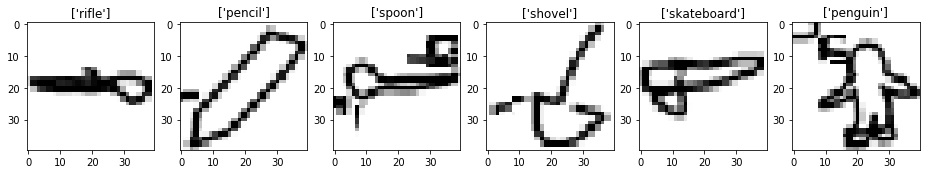

In [5]:
NUM_SAMPLE = 6


# Deterministically generate a few samples
rng = np.random.RandomState(seed=0)
randImg_indeces = rng.randint(0, len(ImageMats), size=NUM_SAMPLE)


# Show the images
plt.figure(figsize=(16,4))
for i, randImgIdx in enumerate(randImg_indeces):
    # Get current image
    curImg = np.reshape( ImageMats[randImgIdx] , (40,40) )
    
    # Show image
    plt.subplot(1,NUM_SAMPLE, (i+1))
    plt.imshow(curImg, cmap='gray_r')
    plt.title(str(Label_df.iloc[[randImgIdx]]['Category'].values))

plt.show()

## Pre-processing
### Scale and flatten the features

In [6]:
# Matrix to store the flatteneed images
ImageVecs = np.empty((np.shape(ImageMats)[0], np.shape(ImageMats)[1]*np.shape(ImageMats)[2] ))

# Flatten and store the images
for i in range(len(ImageMats)):
    ImageVecs[i, :] = ImageMats[i, :, :].flatten()
    
np.shape(ImageVecs)

(10000, 1600)

In [7]:
# Scale images
X_preShuf = ImageVecs / np.max(ImageVecs)

print("Original range: [%f, %f]" % (np.min(ImageVecs),np.max(ImageVecs)))
print("Scaled range: [%f, %f]" % (np.min(X_preShuf),np.max(X_preShuf)))

Original range: [0.000000, 255.000000]
Scaled range: [0.000000, 1.000000]


### Encode the labels

In [8]:
from sklearn import preprocessing

## Get the string labels ##
strLabels = Label_df['Category'].values

## Transform the strings into integer labels
le = preprocessing.LabelEncoder()
intLabels = le.fit_transform(strLabels)
print("%d classes encoded:" % (len(le.classes_)))
print(le.classes_)

31 classes encoded:
['apple' 'empty' 'moustache' 'mouth' 'mug' 'nail' 'nose' 'octagon'
 'paintbrush' 'panda' 'parrot' 'peanut' 'pear' 'pencil' 'penguin' 'pillow'
 'pineapple' 'pool' 'rabbit' 'rhinoceros' 'rifle' 'rollerskates'
 'sailboat' 'scorpion' 'screwdriver' 'shovel' 'sink' 'skateboard' 'skull'
 'spoon' 'squiggle']


In [9]:
# Assign y 
y_preShuf = intLabels
print("Label shape: %s" % str(np.shape(y_preShuf)))

Label shape: (10000,)


### Shuffle data

In [10]:
# Use a subset of data for time-efficient prototyping?
USE_SUBSET = True
SUBSET_SIZE = 3000

## Shuffle data ##
from sklearn.utils import shuffle
X, y = shuffle(X_preShuf, y_preShuf, random_state=100)

## Optionally take subset ##
if USE_SUBSET:
    X = X[0:SUBSET_SIZE]
    y = y[0:SUBSET_SIZE]

print(np.shape(X))
print(np.shape(y))

(3000, 1600)
(3000,)


### Split into sets
#### Split into test and training sets

In [11]:
from sklearn.model_selection import train_test_split
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(np.shape(X_trainVal))
print(np.shape(y_trainVal))
print(np.shape(X_test))
print(np.shape(y_test))

(2400, 1600)
(2400,)
(600, 1600)
(600,)


#### K-fold training and validation sets

In [12]:
from sklearn.model_selection import KFold

K_FOLD = 5

# Initialize and get splits
kf = KFold(n_splits=K_FOLD)
kf.get_n_splits(X_trainVal)

kf

KFold(n_splits=5, random_state=None, shuffle=False)

## Classical Machine Learning Models

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# How many fold cross-validation?
K_FOLD = 2

### Linear Support Vector Machine

In [45]:
from sklearn.svm import LinearSVC

# Parameters to grid search through
parameters = {'loss':['hinge', 'squared_hinge'],
              'penalty':['l2'],
              'C':[0.1, 1.0, 10.0]
             }

# Initialize model and grid search
model = LinearSVC(random_state=0, tol=1e-5)
clf = GridSearchCV(model, parameters, cv=K_FOLD, verbose=1)

# Fit model with grid search
clf.fit(X_trainVal, y_trainVal)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   39.9s finished


GridSearchCV(cv=2, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge', 'squared_hinge'], 'penalty': ['l2'], 'C': [0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [46]:
## Get best parameters ##
best_params = clf.best_params_
print("Best parameters found using %d-fold cross validation:" % K_FOLD)
print(best_params)
print()

## Evaluate on test set ##
# Set best param and train model
model.set_params(**best_params)
model.fit(X_trainVal, y_trainVal)

# See test set performance
y_test_pred = model.predict(X_test)

testAcc = accuracy_score(y_test, y_test_pred)
print("Test set accuracy: %f" % testAcc)

del parameters, best_params, model, clf, y_test_pred, testAcc

Best parameters found using 2-fold cross validation:
{'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}

Test set accuracy: 0.268333


### Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Parameters to grid search through
parameters = {'n_estimators':[100, 200],
              'min_samples_split':[2,4]
             }

# Initialize model and grid search
model = RandomForestClassifier(criterion='gini',
                               n_jobs=None, random_state=0)

clf = GridSearchCV(model, parameters, cv=K_FOLD, verbose=1)

# Fit model with grid search
clf.fit(X_trainVal, y_trainVal)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   39.9s finished


GridSearchCV(cv=2, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge', 'squared_hinge'], 'penalty': ['l2'], 'C': [0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [46]:
## Get best parameters ##
best_params = clf.best_params_
print("Best parameters found using %d-fold cross validation:" % K_FOLD)
print(best_params)
print()

## Evaluate on test set ##
# Set best param and train model
model.set_params(**best_params)
model.fit(X_trainVal, y_trainVal)

# See test set performance
y_test_pred = model.predict(X_test)

testAcc = accuracy_score(y_test, y_test_pred)
print("Test set accuracy: %f" % testAcc)

del parameters, best_params, model, clf, y_test_pred, testAcc

Best parameters found using 2-fold cross validation:
{'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}

Test set accuracy: 0.268333
